# Measure the similarity between two modules
#### Jianfeng
#### 06/06/2024

In [1]:
# import libraries
# import torch
# import torch.nn.functional as F
# from torch_geometric.nn import GCNConv
import os
import csv
import copy
import math
import time
import random
import pickle
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import combinations
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import mse
from scipy import stats
from scipy.stats import spearmanr
from scipy.spatial.distance import cosine
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import rand_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, average_precision_score

In [2]:
# Load gtex data
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/12052023/'
gt = pd.read_csv(data_dir+"new_normed_gtex_gtex_allen_gene.txt", low_memory=False, index_col=0, sep="\t")
region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
               'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
               'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']

# build a dictionary to count the freq of each subject 
sample_subject_list = gt.loc['subject'].tolist()
subject_region_mat = pd.DataFrame(np.zeros((len(set(sample_subject_list)), len(region_pick)), dtype=int))
subject_region_mat.index = sorted(set(sample_subject_list))
subject_region_mat.columns = region_pick
for i in range(gt.shape[1]):
    region = gt.loc['region'][i]
    subject = gt.loc['subject'][i]
    region_idx = region_pick.index(region)
    subject_idx = subject_region_mat.index.tolist().index(subject)
    subject_region_mat.iloc[subject_idx, region_idx] = 1 
# find the subjects to compare
missing_N = 5
# merge modules for every subject
include_subject = [s for s in subject_region_mat.index if subject_region_mat.loc[s].sum()>=(10-missing_N)]

# load allen modules info
ModuleMatch = pd.read_csv('/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/data/modified_data/ModuleMatch.csv', index_col=0)

In [3]:
def jaccard_index(labels_true, labels_pred):
    # Find the pairs in the same cluster for the true labels
    pairs_true = set(combinations(np.where(np.array(labels_true) == i)[0], 2) for i in set(labels_true))
    pairs_true = set().union(*pairs_true)
    # Find the pairs in the same cluster for the predicted labels
    pairs_pred = set(combinations(np.where(np.array(labels_pred) == i)[0], 2) for i in set(labels_pred))
    pairs_pred = set().union(*pairs_pred)
    # Compute the intersection and union of the two sets of pairs
    intersection = len(pairs_true & pairs_pred)
    union = len(pairs_true | pairs_pred)
    # Return the Jaccard Index
    return intersection / union if union != 0 else 0

def new_shuffle_way(gtex_list, N):
    elements_before_N = gtex_list[:N]
    elements_after_N = gtex_list[N:]
    random.shuffle(elements_after_N)
    shuffled_list = elements_before_N + elements_after_N
    
    return shuffled_list

In [4]:
# load gtex module info
subject = 'GTEX-1313W'
save_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/WGCNA/output_modules/'
file_name = f'{subject}_merged_module.csv'
gtex_mat = pd.read_csv(save_dir+f'{subject}_merged_module.csv')

gtex_module_list = gtex_mat['module'].tolist()
gtex_gene_list = gtex_mat['gene'].tolist()
# find module info for the overlapped genes from both datasets
overlapped_genes = [gene for gene in gt.index.tolist()[2:] if gene in ModuleMatch['Gene'].tolist()]
picked_overlapped_genes = [gene for gene in overlapped_genes if gene in gtex_gene_list]
allen_module_list = ModuleMatch['Module.Label'].tolist()
allen_gene_list = ModuleMatch['Gene'].tolist()
# find module info
allen_picked_gene_module_list = [allen_module_list[allen_gene_list.index(gene)] for gene in picked_overlapped_genes]
gtex_picked_gene_module_list = [gtex_module_list[gtex_gene_list.index(gene)] for gene in picked_overlapped_genes]
ori_ri = rand_score(allen_picked_gene_module_list, gtex_picked_gene_module_list)
ori_ari = adjusted_rand_score(allen_picked_gene_module_list, gtex_picked_gene_module_list)
#ori_ji = jaccard_index(allen_picked_gene_module_list, gtex_picked_gene_module_list)
print(f"Original Rand Index: {ori_ri}")
print(f"Original Adjusted Rand Index: {ori_ari}")
#print(f"Original Jaccard Index: {ori_ji}")
permu = 1000
random_ri_list, random_ari_list = [], []

N = 2000
# permutation
for i in range(permu):
    random_list = gtex_picked_gene_module_list.copy()
    random.shuffle(random_list)
    # random_list = new_shuffle_way(allen_picked_gene_module_list, gtex_picked_gene_module_list, N)
    random_ri = rand_score(allen_picked_gene_module_list, random_list)
    random_ari = adjusted_rand_score(allen_picked_gene_module_list, random_list)
    random_ri_list.append(random_ri)
    random_ari_list.append(random_ari)
    #random_ji = jaccard_index(allen_picked_gene_module_list, random_list)
    # print(f"Random rand Index: {random_ri}")
    # print(f"Random adjusted Rand Index: {random_ari}")
    #print(f"Original adjusted Rand Index: {random_ji}")

Original Rand Index: 0.7616318564978277
Original Adjusted Rand Index: 0.010657310891942304


In [5]:
import mpmath
from mpmath import mp

# Calculate mean, standard deviation, and test statistic
n = len(random_ari_list)
mean_list = np.mean(random_ari_list)
std_list = np.std(random_ari_list, ddof=1)  # Sample standard deviation
t_stat = (mean_list - ori_ari) / (std_list / np.sqrt(n))
df = n - 1  # Degrees of freedom

# Set precision
mp.dps = 200  # Adjust precision as needed
# Compute high-precision p-value
p_value_high_precision = 2 * mp.gammainc(df / 2, abs(t_stat) ** 2 / 2, regularized=True)
print(f"Manually Computed P-value: {p_value_high_precision}")

Manually Computed P-value: 1.5309650665786221339833287086609421681679491837237327049758722355503100506601012703976069606173956596139955259831078172213409865913672803288060048080373436735184829289552690631725815562849160851111764e-73742


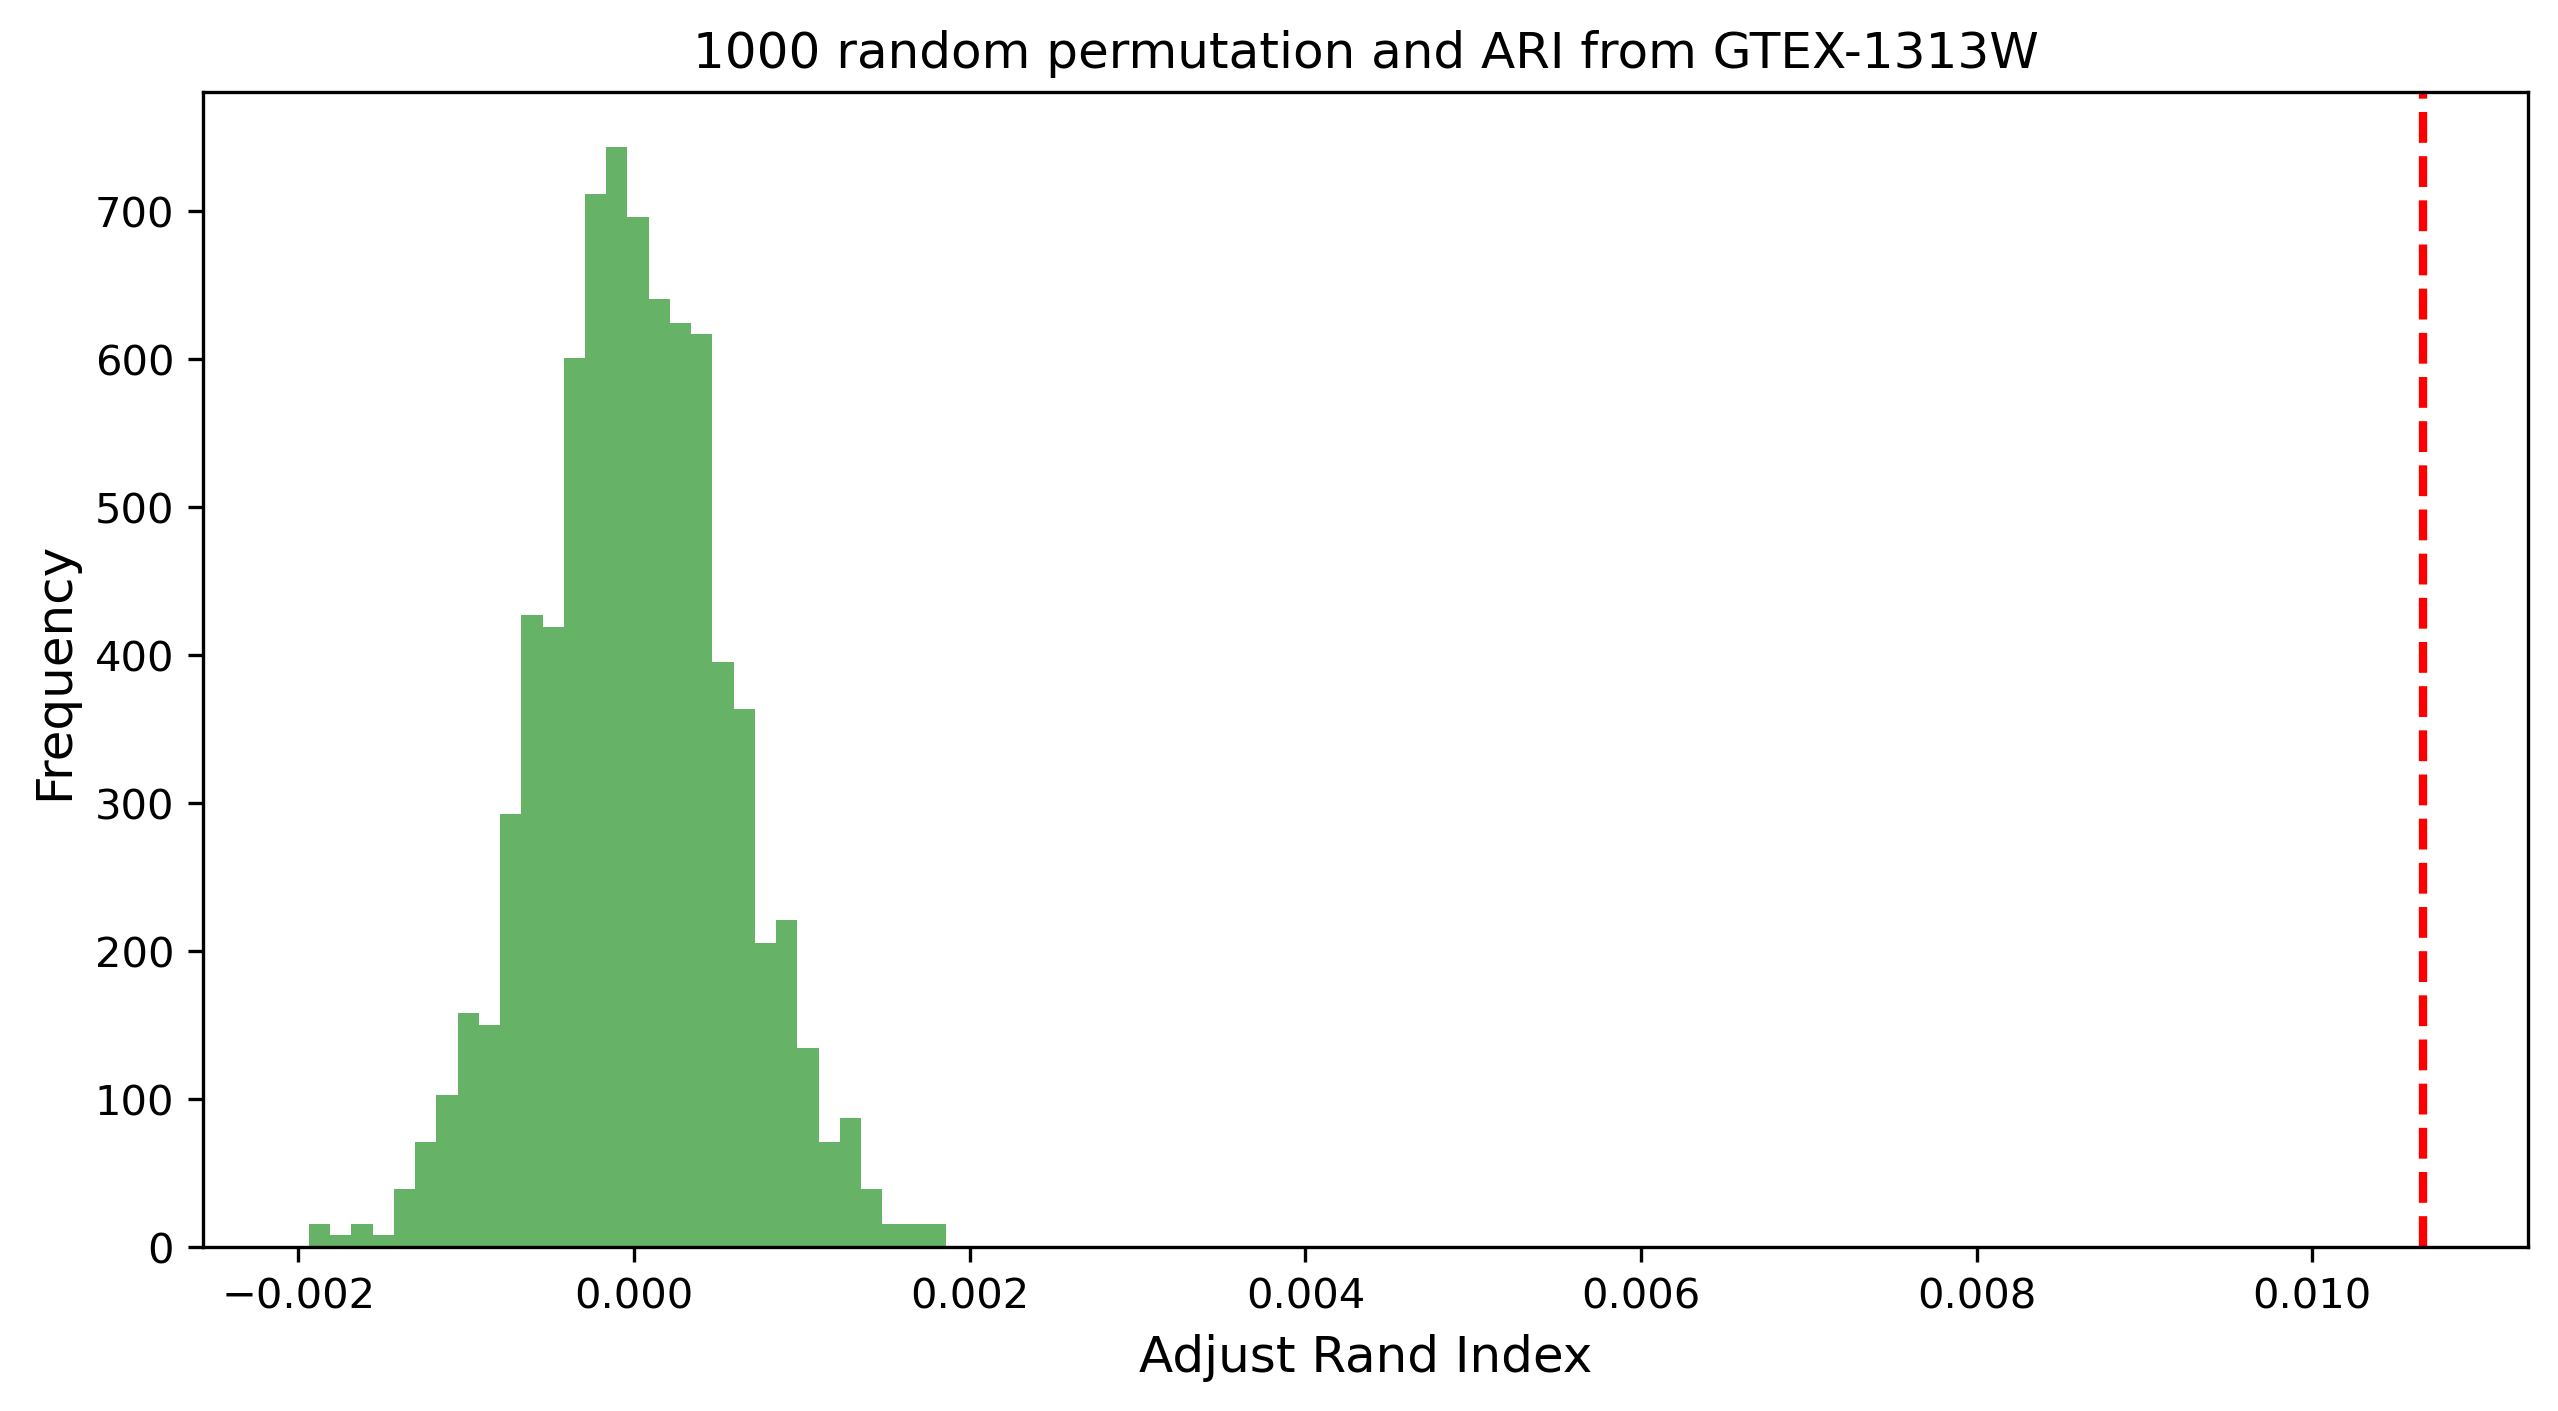

In [8]:
# Plot histogram of the ARI of permutations and the original value with red line
plt.figure(figsize=(10, 5), dpi=300)
plt.hist(random_ari_list, bins=30, density=True, alpha=0.6, color='g')
plt.axvline(x=ori_ari, color='r', linestyle='--', linewidth=2)
plt.xlabel('Adjust Rand Index', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
# plt.title(f'{len(picked_overlapped_genes)}/{len(overlapped_genes)} genes, {permu} permutation and ARI from {subject}', fontsize=10)
plt.title(f'{permu} random permutation and ARI from {subject}', fontsize=12)

plt.show()

In [7]:
save_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/WGCNA/output_modules/'

# compute the mean and std for all subjects
our_ari_mean_list, random_ari_mean_list = [], []

for subject in include_subject:
    # load gtex module info
    file_name = f'{subject}_merged_module.csv'
    gtex_mat = pd.read_csv(save_dir+f'{subject}_merged_module.csv')
    # find the WGCNA module results
    gtex_module_list = gtex_mat['module'].tolist()
    gtex_gene_list = gtex_mat['gene'].tolist()
    # find module info for the overlapped genes from both datasets
    overlapped_genes = [gene for gene in gt.index.tolist()[2:] if gene in ModuleMatch['Gene'].tolist()]
    picked_overlapped_genes = [gene for gene in overlapped_genes if gene in gtex_gene_list]
    allen_module_list = ModuleMatch['Module.Label'].tolist()
    allen_gene_list = ModuleMatch['Gene'].tolist()
    # find module info
    allen_picked_gene_module_list = [allen_module_list[allen_gene_list.index(gene)] for gene in picked_overlapped_genes]
    gtex_picked_gene_module_list = [gtex_module_list[gtex_gene_list.index(gene)] for gene in picked_overlapped_genes]
    ori_ri = rand_score(allen_picked_gene_module_list, gtex_picked_gene_module_list)
    ori_ari = adjusted_rand_score(allen_picked_gene_module_list, gtex_picked_gene_module_list)
    #ori_ji = jaccard_index(allen_picked_gene_module_list, gtex_picked_gene_module_list)
    print(f"Original Rand Index: {ori_ri}")
    print(f"Original Adjusted Rand Index: {ori_ari}")
    #print(f"Original Jaccard Index: {ori_ji}")
    permu = 1000
    random_ri_list, random_ari_list = [], []

    N = 2000
    # permutation
    for i in range(permu):
        random_list = gtex_picked_gene_module_list.copy()
        random.shuffle(random_list)
        # random_list = new_shuffle_way(allen_picked_gene_module_list, gtex_picked_gene_module_list, N)
        random_ri = rand_score(allen_picked_gene_module_list, random_list)
        random_ari = adjusted_rand_score(allen_picked_gene_module_list, random_list)
        random_ri_list.append(random_ri)
        random_ari_list.append(random_ari)
        #random_ji = jaccard_index(allen_picked_gene_module_list, random_list)
        # print(f"Random rand Index: {random_ri}")
        # print(f"Random adjusted Rand Index: {random_ari}")
        #print(f"Original adjusted Rand Index: {random_ji}")
    # compute the mean of random ari
    random_ari_mean_list.append(np.mean(random_ari_list))
    our_ari_mean_list.append(ori_ari)

Original Rand Index: 0.6676221870764845
Original Adjusted Rand Index: 0.016003669069894585
Original Rand Index: 0.8302829700452613
Original Adjusted Rand Index: 0.019467694156524832
Original Rand Index: 0.7961096151613053
Original Adjusted Rand Index: 0.03296583077517907
Original Rand Index: 0.8321476690722717
Original Adjusted Rand Index: 0.017350893581356584
Original Rand Index: 0.8211672790463802
Original Adjusted Rand Index: 0.017406176318592977
Original Rand Index: 0.7855699863315985
Original Adjusted Rand Index: 0.008424080716339542
Original Rand Index: 0.6604306366777363
Original Adjusted Rand Index: 0.015426508343998025
Original Rand Index: 0.8787425507393679
Original Adjusted Rand Index: 0.022138624489339634
Original Rand Index: 0.8102786541478337
Original Adjusted Rand Index: 0.013391090848761647
Original Rand Index: 0.8217115867178321
Original Adjusted Rand Index: 0.013952858813414922
Original Rand Index: 0.8087060393555636
Original Adjusted Rand Index: 0.018827712382208695



KeyboardInterrupt



In [ ]:
print(f'There are {len(include_subject)} with at least 5 regions in GTEx')
print(f'The mean of ARIs for GTEx subjects is: {np.mean(our_ari_mean_list)}')
print(f'The std of ARIs for GTEx subjects is: {np.std(our_ari_mean_list)}')

### distribution of the number of genes with color greys 

In [ ]:
# find the subjects to compare
missing_N = 5
# merge modules for every subject
include_subject = [s for s in subject_region_mat.index if subject_region_mat.loc[s].sum()>=(10-missing_N)]
save_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/WGCNA/output_modules/'
n_grey_gene_list = []
# iterate over subjects
for subject in include_subject:
    file_name = f'{subject}_merged_module.csv'
    gtex_mat = pd.read_csv(save_dir+f'{subject}_merged_module.csv')
    n_grey_gene = 15044-len(gtex_mat)
    n_grey_gene_list.append(n_grey_gene)

In [ ]:
plt.figure(figsize=(6, 6))
plt.hist(n_grey_gene_list, bins=5, edgecolor='black')  # You can adjust the number of bins as needed
# Adding titles and labels
plt.title(f'Numbers of genes with color grey, {len(include_subject)} GTEx subjects', fontsize=10)
plt.xlabel('')
plt.ylabel('Counts')
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], [1, 2, 3, 4, 5])
# Show the plot
plt.show()

### Distribution of the number of modules after merging modules

In [ ]:
# find the subjects to compare
missing_N = 5
# merge modules for every subject
include_subject = [s for s in subject_region_mat.index if subject_region_mat.loc[s].sum()>=(10-missing_N)]
save_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/WGCNA/output_modules/'
n_module_list = []
# iterate over subjects
for subject in include_subject:
    file_name = f'{subject}_merged_module.csv'
    gtex_mat = pd.read_csv(save_dir+f'{subject}_merged_module.csv')
    n_module_list.append(len(set(gtex_mat['module'])))

In [ ]:
plt.figure(figsize=(6, 6))
plt.hist(n_module_list, bins=30, edgecolor='black')  # You can adjust the number of bins as needed
# Adding titles and labels
plt.title(f'{len(include_subject)} GTEx subjects, average # module: {np.mean(n_module_list):.2f}', fontsize=10)
plt.xlabel('')
plt.ylabel('Counts')
# Show the plot
plt.show()